# Live cofing: Pytorch MNIST

### Importing packages

In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt

from torch.autograd import Variable
from torchvision import datasets, transforms

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

/home/thytu/.local/lib/python3.8/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


### Creating our network

In [2]:
class Network(nn.Module):
  def __init__(self):
    super().__init__()
    # kernel_size == size of the filter
    # out_channels == number of filters
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
    self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=5)
    
    self.fc1 = nn.Linear(in_features=12*4*4, out_features=120)
    self.fc2 = nn.Linear(in_features=120, out_features=60)
    self.out = nn.Linear(in_features=60, out_features=10)
    
  def forward(self, t):
    t = self.conv1(t)
    t = F.relu(t)
    t = F.max_pool2d(t, kernel_size=2, stride=2)
    
    t = self.conv2(t)
    t = F.relu(t)
    t = F.max_pool2d(t, kernel_size=2, stride=2)

    t = t.reshape(-1, 12 * 4 * 4) # the 4 * 4 is the height and width of the input channel
    t = self.fc1(t)
    t = F.relu(t)
    
    t = self.fc2(t)
    t = F.relu(t)
    
    t = self.out(t)
    # t = F.softmax(t, dim=1) with Cross Entropy loss function don't need softmax beacause LCE already do it
    
    return t
    

## CNN output size formula (square)
- we have an $n * n$ input
- we have an $f * f$ filter
- we have a padding $p$
- we have a filter $f$
- we have an output size $O$

## $O = \frac{n - f +2p}{s} + 1$


**28 -> $\frac{28 - 5 +2*0}{1} + 1$ -> 24**<br>
[1, 1, 28, 28] -> conv1 -> [1, 6, 24, 24]

**28 -> $\frac{24 - 2 +2*0}{2} + 1$ -> 12**<br>
[1, 6, 24, 24] -> maxpool2d(2 * 2) -> [1, 6, 12, 12]

**28 -> $\frac{12 - 5 +2*0}{1} + 1$ -> 8**<br>
[1, 6, 12, 12] -> conv2 -> [1, 12, 8, 8]

**28 -> $\frac{8 - 2 +2*0}{2} + 1$ -> 4**<br>
inp[1, 12, 8, 8]ut -> maxpool2d(2 * 2) -> [1, 12, 4, 4]

## CNN output size formula (non square)
- we have an $Nh * Nw$ input
- we have an $Fh * Fw$ filter
- we have a padding $p$
- we have a filter $f$
- we have an output size $O$

## $Oh = \frac{Nh - Fh +2p}{s} + 1$
## $Ow = \frac{Nw - Fw +2p}{s} + 1$

### Let's take a look at our network

In [3]:
network = Network().to(device)

print(network)

print(network.conv1.weight.shape)
print(network.out.weight.shape)

Network(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 12, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=192, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=60, bias=True)
  (out): Linear(in_features=60, out_features=10, bias=True)
)
torch.Size([6, 1, 5, 5])
torch.Size([10, 60])


### Downloading our dataset

In [4]:
train_set = torchvision.datasets.FashionMNIST(
  root="./data/FashionMNIST",
  train=True,
  download=True,
  transform=transforms.Compose([
    transforms.ToTensor()
  ])
)

test_set = torchvision.datasets.FashionMNIST(
  root="./data/FashionMNIST",
  train=False,
  download=True,
  transform=transforms.Compose([
    transforms.ToTensor()
  ])
)

### Let's take a look at our sample

In [5]:
sample = next(iter(train_set))
image, label = sample
image.shape

torch.Size([1, 28, 28])

### Displaying a sample

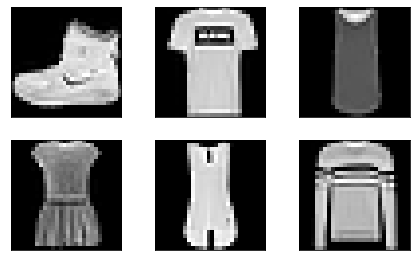

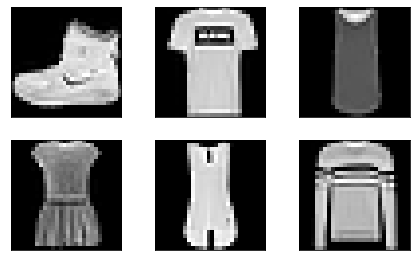

In [6]:
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(train_set[i][0].reshape(28, 28, 1), cmap='gray', interpolation='none')
  plt.xticks([])
  plt.yticks([])
fig

### Creating a batch of size 1

In [7]:
image.unsqueeze(0).shape

torch.Size([1, 1, 28, 28])

### Making our first prediction

In [8]:
prediction = network(image.unsqueeze(0))

print(prediction.shape)
print(prediction)
print(f"prediction:{prediction.argmax(dim=1)} label:{label}")

torch.Size([1, 10])
tensor([[ 0.0901,  0.0695,  0.1632,  0.0876,  0.1009, -0.1131, -0.0179, -0.0681,
         -0.0973, -0.0959]], grad_fn=<AddmmBackward>)
prediction:tensor([2]) label:9


### Creating our loader

In [9]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=64)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=64)

### Let's take a look at our sample

In [10]:
images, labels = next(iter(train_loader))
images.shape

torch.Size([64, 1, 28, 28])

### Let's take a look at our predictions

In [11]:
predictions = network(images)
print(prediction.shape)

torch.Size([1, 10])


### Creating get_num_correct()

In [12]:
def get_num_correct(preds, labels):
  return preds.argmax(dim=1).eq(labels).sum().item()

get_num_correct(predictions, labels)

7

### Let's go a bit further

In [13]:
loss = F.cross_entropy(predictions, labels)

print(loss.item())
loss.backward() # calculating the gradient
print(network.fc1.weight.grad)

2.2996673583984375
tensor([[ 0.0000e+00,  1.3269e-05,  5.6684e-07,  ...,  0.0000e+00,
          0.0000e+00,  1.8764e-05],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [-1.0900e-04, -3.5326e-05, -4.8333e-05,  ..., -5.3494e-04,
         -4.2395e-04, -4.5462e-04],
        ...,
        [-1.6577e-04, -4.3670e-05,  8.5731e-06,  ...,  4.2824e-04,
          1.2356e-05,  1.8318e-04],
        [ 1.2508e-05,  6.1037e-06,  5.9936e-06,  ...,  1.5294e-04,
          1.5144e-04,  1.7504e-04],
        [-4.2968e-05, -5.5090e-05, -1.3621e-05,  ..., -4.1280e-04,
         -3.5609e-04, -3.7479e-04]])


### Our optimizer ?

In [14]:
optimizer = optim.Adam(network.parameters(), lr=0.01)
optimizer.step()

### How can we train our model ?

In [15]:
predictions = network(images)
print(get_num_correct(predictions, labels))

loss = F.cross_entropy(predictions, labels)
EPOCHS = 5
LEARNING_RATE = 0.01
BATCH_SIZE = 64

network = Network().to(device)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE)
optimizer = optim.Adam(network.parameters(), lr=LEARNING_RATE)

print(loss.item())

10
2.2445404529571533


### Let's put it all together

In [16]:
EPOCHS = 5
LEARNING_RATE = 0.01
BATCH_SIZE = 64

network = Network().to(device)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE)
optimizer = optim.Adam(network.parameters(), lr=LEARNING_RATE)

TRAINING_SIZE = len(iter(train_loader)) * BATCH_SIZE
TESTING_SIZE = len(iter(test_loader)) * BATCH_SIZE


training_losses = []
training_accuracies = []

testing_losses = []
testing_accuracies = []

def train():
  network.train()
  correct_in_episode = 0
  episode_loss = 0
  
  for batch in train_loader:
    images, labels = batch
    
    predictions = network(images)
    loss = F.cross_entropy(predictions, labels)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    episode_loss += loss.item()
    correct_in_episode += get_num_correct(predictions, labels)

  training_losses.append(episode_loss)
  training_accuracies.append(correct_in_episode * 100 / TRAINING_SIZE)
  print(f"Epoch: {epoch + 1} accuracy: {correct_in_episode * 100 / TRAINING_SIZE:.2f} loss: {episode_loss:.3f}", end="\t")
  
def test():
  network.eval()
  episode_loss = 0
  correct_in_episode = 0
  
  with torch.no_grad():
    for batch in test_loader:
      images, labels = batch

      predictions = network(images)
      loss = F.cross_entropy(predictions, labels)

      episode_loss = loss.item()
      correct_in_episode += get_num_correct(predictions, labels)
  
  testing_losses.append(episode_loss)
  testing_accuracies.append(correct_in_episode * 100 / TESTING_SIZE)
  print(f'Validation: Accuracy: {correct_in_episode * 100 / TESTING_SIZE:.2f} loss: {episode_loss:.3f}')

### It's time to train our model !

In [17]:
for epoch in range(EPOCHS):
  train()
  test()

Epoch: 1 accuracy: 79.12 loss: 521.604	Validation: Accuracy: 82.22 loss: 0.247
Epoch: 2 accuracy: 85.34 loss: 372.905	Validation: Accuracy: 84.09 loss: 0.458
Epoch: 3 accuracy: 86.28 loss: 345.662	Validation: Accuracy: 84.64 loss: 0.305
Epoch: 4 accuracy: 86.89 loss: 333.213	Validation: Accuracy: 84.88 loss: 0.272
Epoch: 5 accuracy: 87.44 loss: 321.035	Validation: Accuracy: 84.84 loss: 0.243


### Evolution of the loss

Text(0, 0.5, 'Loss')

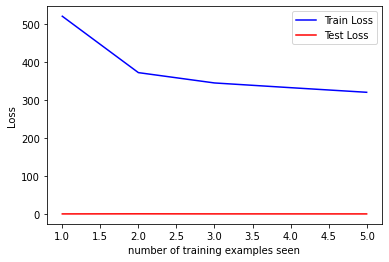

In [18]:
fig = plt.figure()

plt.plot(list(range(1, len(training_losses)+1)), training_losses, color='blue')
plt.plot(list(range(1, len(testing_losses)+1)), testing_losses, color='red')

plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('Loss')

### Evolution of the accuracy

Text(0, 0.5, 'Accuracy')

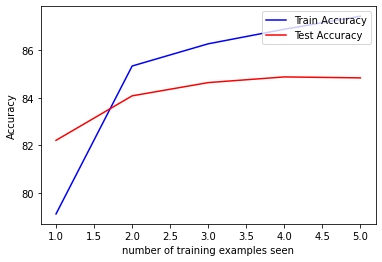

In [19]:
fig = plt.figure()

plt.plot(list(range(1, len(training_accuracies)+1)), training_accuracies, color='blue')
plt.plot(list(range(1, len(testing_accuracies)+1)), testing_accuracies, color='red')

plt.legend(['Train Accuracy', 'Test Accuracy'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('Accuracy')